In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numba import jit,cuda

In [55]:
BATCH_SIZE = 64
IMAGE_SIZE = 300
train_path = "train2"
test_path = "test2"

In [56]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
    train_datagen = ImageDataGenerator(rescale=(1./255),
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     brightness_range=[0.2,1.2],
                                     rotation_range=0.2,
                                     horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

    test_datagen = ImageDataGenerator(rescale=1./255)

  
    test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))
    return train_generator, test_generator

In [57]:
train_generator,test_generator=train_val_generators(train_path, test_path,IMAGE_SIZE,BATCH_SIZE)

Found 840 images belonging to 1 classes.
Found 312 images belonging to 1 classes.


(64, 300, 300, 3)
[1.]


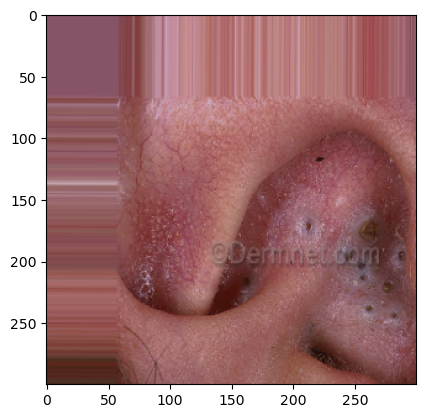

(64, 300, 300, 3)
[1.]


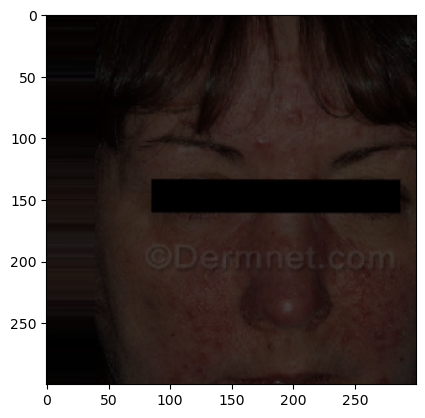

(64, 300, 300, 3)
[1.]


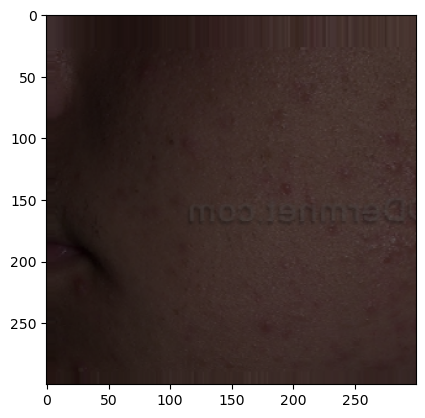

(64, 300, 300, 3)
[1.]


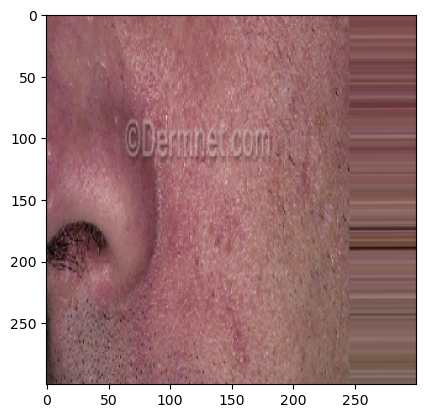

(64, 300, 300, 3)
[1.]


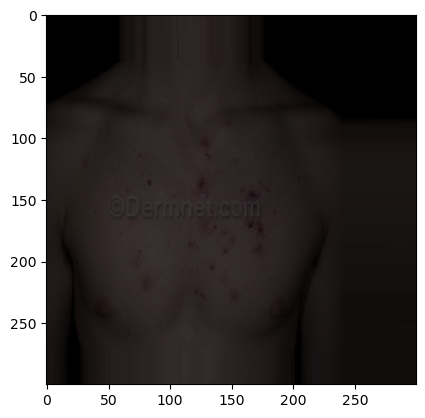

In [58]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)  
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [86]:
class_names = train_generator.class_indices
class_names


{'Acne and Rosacea Photos': 0}

In [61]:
NUMBER_OF_CLASSES = len(class_names)


In [62]:
print(f'number of classes : {NUMBER_OF_CLASSES}')


number of classes : 1


In [63]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [64]:
base_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')


In [65]:
for layer in base_model.layers:
    layer.trainable = True

In [66]:
def output_of_last_layer(pre_trained_model, limit_layer):
    last_desired_layer = pre_trained_model.get_layer(limit_layer)
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

In [67]:
last_output = output_of_last_layer(base_model,'mixed5')

last layer output shape:  (None, 17, 17, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 768), dtype=tf.float32, name=None), name='mixed5/concat:0', description="created by layer 'mixed5'")


In [68]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [70]:
history = model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs = 40, 
    callbacks=[custom_early_stopping])

Epoch 1/20


C:\Users\91901\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 189s 12s/step - loss: 9.5461 - accuracy: 1.0000 - val_loss: 4.3197 - val_accuracy: 1.0000
Epoch 2/20
14/14 [==============================] - 158s 11s/step - loss: 2.8665 - accuracy: 1.0000 - val_loss: 1.5776 - val_accuracy: 1.0000
Epoch 3/20
14/14 [==============================] - 156s 11s/step - loss: 1.0601 - accuracy: 1.0000 - val_loss: 0.5347 - val_accuracy: 1.0000
Epoch 4/20
14/14 [==============================] - 157s 11s/step - loss: 0.3244 - accuracy: 1.0000 - val_loss: 0.1619 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 155s 11s/step - loss: 0.0906 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 157s 11s/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 156s 11s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/20
14/14 

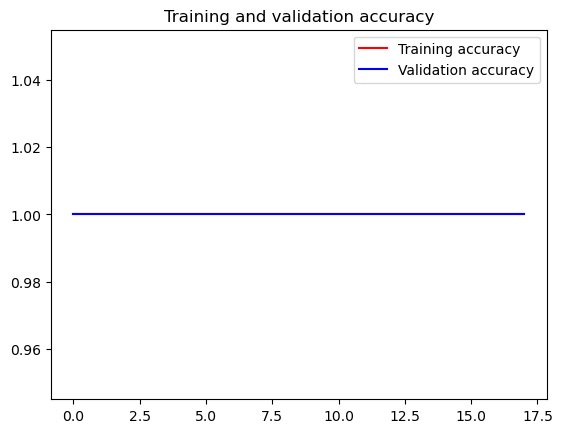

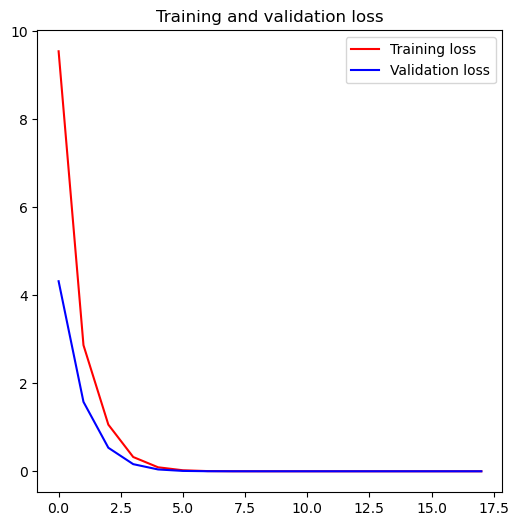

<Figure size 600x600 with 0 Axes>

In [74]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))


plt.show()

5/5 [==============================] - 8s 1s/step


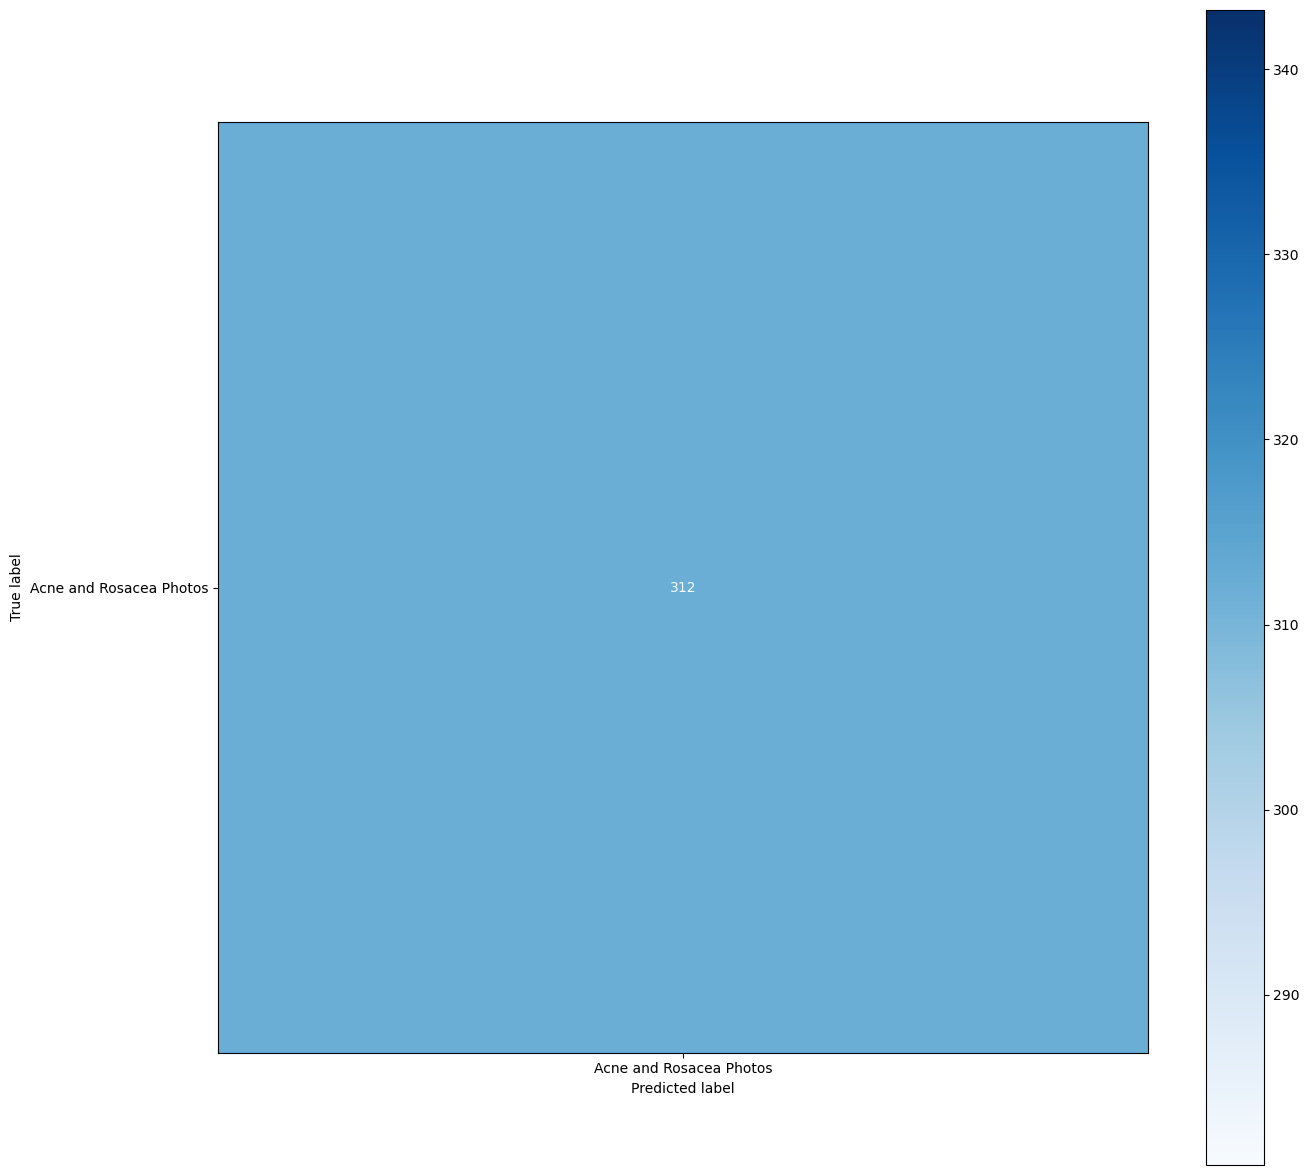

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np

test_true=test_generator.classes
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

In [89]:
model.save('model_test')


INFO:tensorflow:Assets written to: model_test\assets


INFO:tensorflow:Assets written to: model_test\assets
